In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [3]:
import mlxtend
print(mlxtend.__version__)


0.23.4


In [ ]:

# Load dataset
df = pd.read_excel('Online Retail.xlsx')

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic info about the dataset
print("\nFirst 5 rows of the dataset:")
df.head()

Dataset loaded successfully!
Dataset shape: (541909, 8)

First 5 rows of the dataset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
# Part A: Data Preparation
print("=== PART A: DATA PREPARATION ===")

# 1. Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print("✓ InvoiceDate converted to datetime")

# 2. Remove cancellations and duplicates
initial_shape = df.shape[0]

# Remove cancellations (invoices starting with 'C' or negative quantities)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C', na=False)]
df = df[df['Quantity'] > 0]

# Remove duplicates
df = df.drop_duplicates()

# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

final_shape = df.shape[0]
print(f"✓ Data cleaning complete. Removed {initial_shape - final_shape} rows")
print(f"✓ Final dataset shape: {df.shape}")

# Create TotalAmount column (using UnitPrice instead of Price)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
print("✓ TotalAmount column created")

=== PART A: DATA PREPARATION ===
✓ InvoiceDate converted to datetime
✓ Data cleaning complete. Removed 0 rows
✓ Final dataset shape: (392732, 9)
✓ TotalAmount column created


In [6]:
# Compute RFM per CustomerID
print("\nComputing RFM features...")

# Set reference date (day after last invoice)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM using your actual column names
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'     # Monetary
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print("✓ RFM features computed")
print(rfm_df.head())

print(f"\nReference date for Recency calculation: {reference_date.date()}")


Computing RFM features...
✓ RFM features computed
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40

Reference date for Recency calculation: 2011-12-10



=== HANDLING OUTLIERS AND SCALING ===
1. RFM Distributions Before Outlier Treatment:
           Recency    Frequency       Monetary
count  4339.000000  4339.000000    4339.000000
mean     92.518322     4.271952    2048.215924
std     100.009747     7.705493    8984.248352
min       1.000000     1.000000       0.000000
25%      18.000000     1.000000     306.455000
50%      51.000000     2.000000     668.560000
75%     142.000000     5.000000    1660.315000
max     374.000000   210.000000  280206.020000


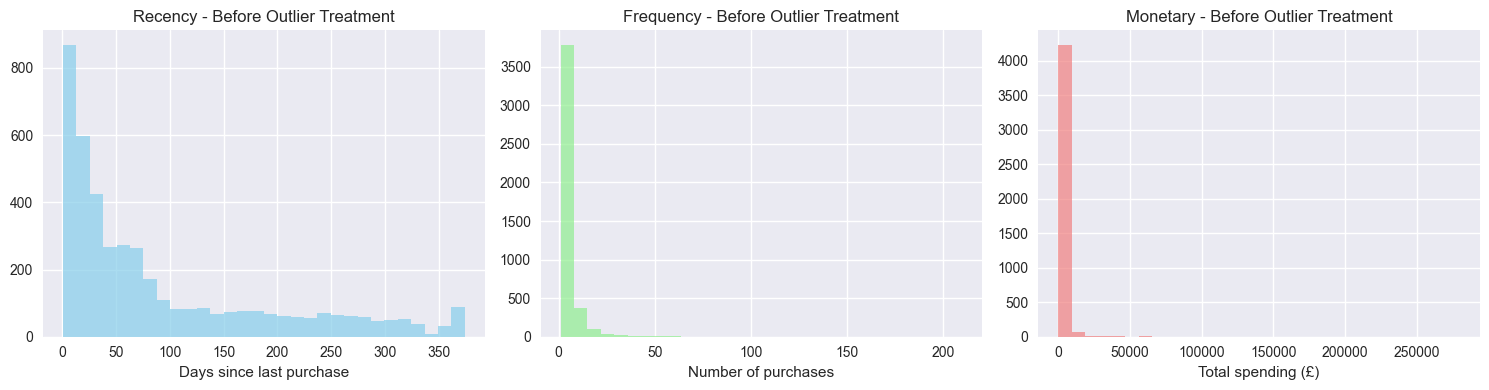


2. Removing outliers using IQR method...
   After Recency outlier removal: 4184 customers
   After Frequency outlier removal: 3900 customers
   After Monetary outlier removal: 3605 customers
✓ Outliers removed: 734 customers (16.9%)

3. RFM Distributions After Outlier Treatment:
           Recency    Frequency     Monetary
count  3605.000000  3605.000000  3605.000000
mean     91.570042     2.725104   810.283097
std      89.473775     2.078815   700.492743
min       1.000000     1.000000     0.000000
25%      22.000000     1.000000   285.890000
50%      57.000000     2.000000   576.900000
75%     144.000000     4.000000  1138.000000
max     327.000000    11.000000  3029.870000


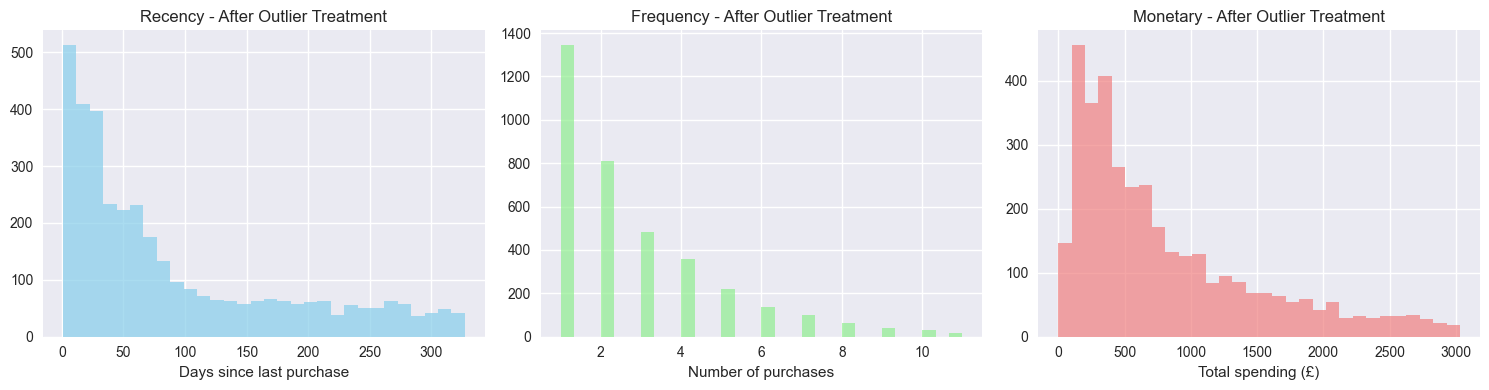

In [8]:
#  Handle outliers and scale features
print("\n=== HANDLING OUTLIERS AND SCALING ===")

# First, examine the RFM distributions before outlier treatment
print("1. RFM Distributions Before Outlier Treatment:")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].describe())

# Visualize original distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

rfm_df['Recency'].hist(ax=axes[0], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Recency - Before Outlier Treatment')
axes[0].set_xlabel('Days since last purchase')

rfm_df['Frequency'].hist(ax=axes[1], bins=30, alpha=0.7, color='lightgreen')
axes[1].set_title('Frequency - Before Outlier Treatment')
axes[1].set_xlabel('Number of purchases')

rfm_df['Monetary'].hist(ax=axes[2], bins=30, alpha=0.7, color='lightcoral')
axes[2].set_title('Monetary - Before Outlier Treatment')
axes[2].set_xlabel('Total spending (£)')

plt.tight_layout()
plt.show()

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # For Recency, we only care about upper bound (very recent customers are good)
    if column == 'Recency':
        return df[df[column] <= upper_bound]
    else:  # For Frequency and Monetary, we want both bounds
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from each RFM component
print("\n2. Removing outliers using IQR method...")
initial_customers = rfm_df.shape[0]

rfm_clean = remove_outliers_iqr(rfm_df, 'Recency')
print(f"   After Recency outlier removal: {rfm_clean.shape[0]} customers")

rfm_clean = remove_outliers_iqr(rfm_clean, 'Frequency')
print(f"   After Frequency outlier removal: {rfm_clean.shape[0]} customers")

rfm_clean = remove_outliers_iqr(rfm_clean, 'Monetary')
print(f"   After Monetary outlier removal: {rfm_clean.shape[0]} customers")

final_customers = rfm_clean.shape[0]
removed_customers = initial_customers - final_customers
print(f"✓ Outliers removed: {removed_customers} customers ({removed_customers/initial_customers*100:.1f}%)")

# Compare distributions after outlier treatment
print("\n3. RFM Distributions After Outlier Treatment:")
print(rfm_clean[['Recency', 'Frequency', 'Monetary']].describe())

# Visualize after outlier treatment
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

rfm_clean['Recency'].hist(ax=axes[0], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Recency - After Outlier Treatment')
axes[0].set_xlabel('Days since last purchase')

rfm_clean['Frequency'].hist(ax=axes[1], bins=30, alpha=0.7, color='lightgreen')
axes[1].set_title('Frequency - After Outlier Treatment')
axes[1].set_xlabel('Number of purchases')

rfm_clean['Monetary'].hist(ax=axes[2], bins=30, alpha=0.7, color='lightcoral')
axes[2].set_title('Monetary - After Outlier Treatment')
axes[2].set_xlabel('Total spending (£)')

plt.tight_layout()
plt.show()


4. Scaling features using StandardScaler...
✓ Features scaled successfully

Scaled RFM statistics:
            Recency     Frequency      Monetary
count  3.605000e+03  3.605000e+03  3.605000e+03
mean  -6.898473e-17  8.475267e-17  1.576794e-17
std    1.000139e+00  1.000139e+00  1.000139e+00
min   -1.012393e+00 -8.299650e-01 -1.156894e+00
25%   -7.776546e-01 -8.299650e-01 -7.487099e-01
50%   -3.864243e-01 -3.488549e-01 -3.332161e-01
75%    5.860626e-01  6.133654e-01  4.679026e-01
max    2.631638e+00  3.981136e+00  3.169048e+00


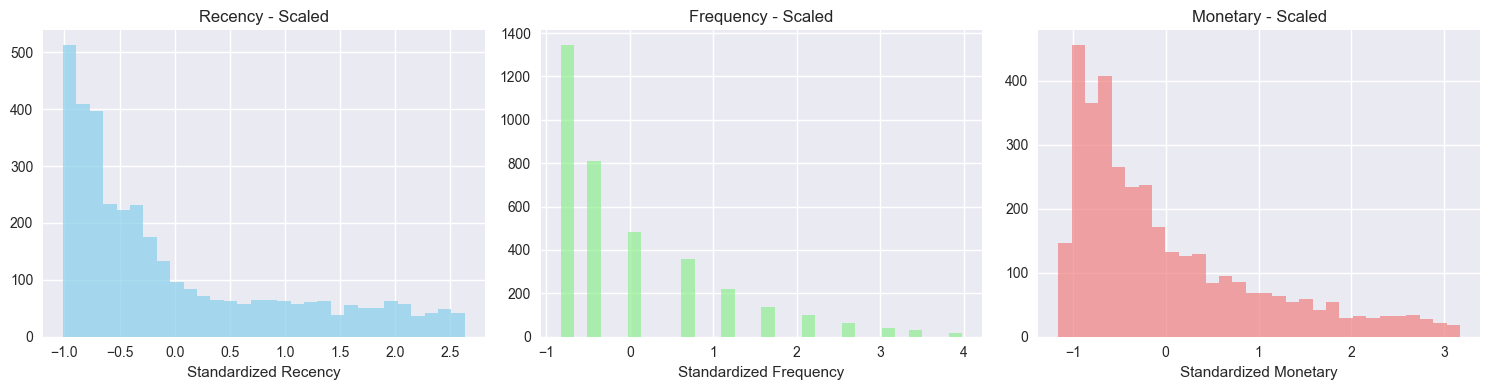


✓ Outlier handling and scaling complete
✓ Final clean dataset: 3605 customers
✓ Ready for RFM segmentation analysis


In [9]:
# 4. Scale features for consistent analysis
print("\n4. Scaling features using StandardScaler...")

# Initialize scaler
scaler = StandardScaler()

# Create a copy for scaled data
rfm_scaled = rfm_clean.copy()

# Scale the RFM features
rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(
    rfm_scaled[['Recency', 'Frequency', 'Monetary']]
)

print("✓ Features scaled successfully")
print("\nScaled RFM statistics:")
print(rfm_scaled[['Recency', 'Frequency', 'Monetary']].describe())

# Visualize scaled distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

rfm_scaled['Recency'].hist(ax=axes[0], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Recency - Scaled')
axes[0].set_xlabel('Standardized Recency')

rfm_scaled['Frequency'].hist(ax=axes[1], bins=30, alpha=0.7, color='lightgreen')
axes[1].set_title('Frequency - Scaled')
axes[1].set_xlabel('Standardized Frequency')

rfm_scaled['Monetary'].hist(ax=axes[2], bins=30, alpha=0.7, color='lightcoral')
axes[2].set_title('Monetary - Scaled')
axes[2].set_xlabel('Standardized Monetary')

plt.tight_layout()
plt.show()

print("\n✓ Outlier handling and scaling complete")
print(f"✓ Final clean dataset: {rfm_clean.shape[0]} customers")
print(f"✓ Ready for RFM segmentation analysis")

In [10]:
# Exploratory Data Analysis
print("=== PART B: EXPLORATORY DATA ANALYSIS ===")

# 1. Summary stats for R, F, M
print("\n1. SUMMARY STATISTICS FOR R, F, M:")
print("=" * 50)

# Detailed summary statistics
summary_stats = rfm_clean[['Recency', 'Frequency', 'Monetary']].describe()
print(summary_stats)

# Additional insights
print("\nAdditional Insights:")
print(f"• Total Customers Analyzed: {rfm_clean.shape[0]:,}")
print(f"• Median Recency: {rfm_clean['Recency'].median():.1f} days")
print(f"• Median Frequency: {rfm_clean['Frequency'].median():.1f} purchases")
print(f"• Median Monetary Value: £{rfm_clean['Monetary'].median():.2f}")
print(f"• Recency Range: {rfm_clean['Recency'].min():.0f} to {rfm_clean['Recency'].max():.0f} days")
print(f"• Frequency Range: {rfm_clean['Frequency'].min():.0f} to {rfm_clean['Frequency'].max():.0f} purchases")
print(f"• Monetary Range: £{rfm_clean['Monetary'].min():.2f} to £{rfm_clean['Monetary'].max():.2f}")

=== PART B: EXPLORATORY DATA ANALYSIS ===

1. SUMMARY STATISTICS FOR R, F, M:
           Recency    Frequency     Monetary
count  3605.000000  3605.000000  3605.000000
mean     91.570042     2.725104   810.283097
std      89.473775     2.078815   700.492743
min       1.000000     1.000000     0.000000
25%      22.000000     1.000000   285.890000
50%      57.000000     2.000000   576.900000
75%     144.000000     4.000000  1138.000000
max     327.000000    11.000000  3029.870000

Additional Insights:
• Total Customers Analyzed: 3,605
• Median Recency: 57.0 days
• Median Frequency: 2.0 purchases
• Median Monetary Value: £576.90
• Recency Range: 1 to 327 days
• Frequency Range: 1 to 11 purchases
• Monetary Range: £0.00 to £3029.87



2. DISTRIBUTION VISUALIZATIONS:


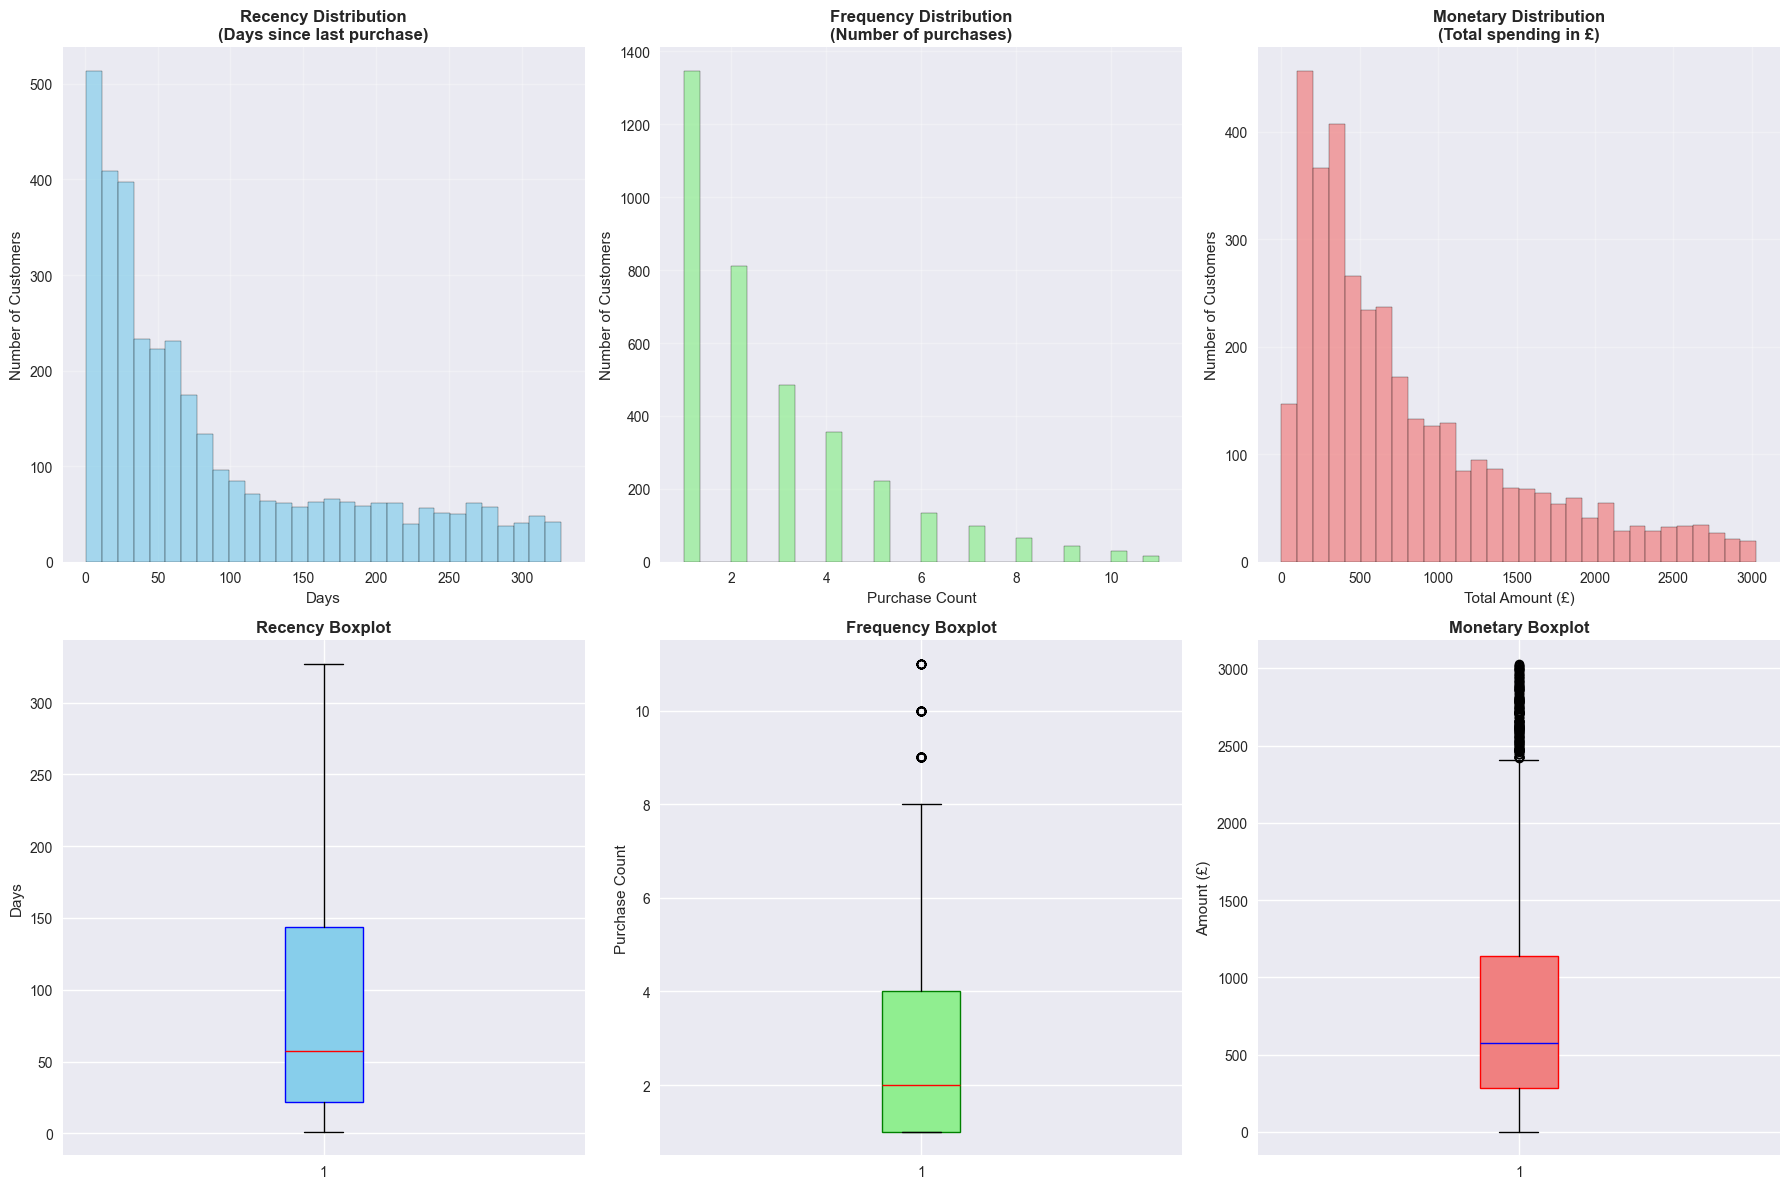

Boxplot Insights:
• Recency IQR: 22.0 - 144.0 days
• Frequency IQR: 1.0 - 4.0 purchases
• Monetary IQR: £285.89 - £1138.00


In [11]:
# 2. Plot histograms and boxplots
print("\n2. DISTRIBUTION VISUALIZATIONS:")
print("=" * 50)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Histograms
# Recency Histogram
axes[0, 0].hist(rfm_clean['Recency'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Recency Distribution\n(Days since last purchase)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].grid(True, alpha=0.3)

# Frequency Histogram
axes[0, 1].hist(rfm_clean['Frequency'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Frequency Distribution\n(Number of purchases)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Purchase Count')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].grid(True, alpha=0.3)

# Monetary Histogram
axes[0, 2].hist(rfm_clean['Monetary'], bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Monetary Distribution\n(Total spending in £)', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Total Amount (£)')
axes[0, 2].set_ylabel('Number of Customers')
axes[0, 2].grid(True, alpha=0.3)

# Boxplots
# Recency Boxplot
axes[1, 0].boxplot(rfm_clean['Recency'], patch_artist=True, 
                   boxprops=dict(facecolor='skyblue', color='blue'),
                   medianprops=dict(color='red'))
axes[1, 0].set_title('Recency Boxplot', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Days')

# Frequency Boxplot
axes[1, 1].boxplot(rfm_clean['Frequency'], patch_artist=True,
                   boxprops=dict(facecolor='lightgreen', color='green'),
                   medianprops=dict(color='red'))
axes[1, 1].set_title('Frequency Boxplot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Purchase Count')

# Monetary Boxplot
axes[1, 2].boxplot(rfm_clean['Monetary'], patch_artist=True,
                   boxprops=dict(facecolor='lightcoral', color='red'),
                   medianprops=dict(color='blue'))
axes[1, 2].set_title('Monetary Boxplot', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Amount (£)')

plt.tight_layout()
plt.show()

# Print boxplot insights
print("Boxplot Insights:")
print(f"• Recency IQR: {rfm_clean['Recency'].quantile(0.25):.1f} - {rfm_clean['Recency'].quantile(0.75):.1f} days")
print(f"• Frequency IQR: {rfm_clean['Frequency'].quantile(0.25):.1f} - {rfm_clean['Frequency'].quantile(0.75):.1f} purchases")
print(f"• Monetary IQR: £{rfm_clean['Monetary'].quantile(0.25):.2f} - £{rfm_clean['Monetary'].quantile(0.75):.2f}")


3. CORRELATION MATRIX:
Correlation Matrix:
            Recency  Frequency  Monetary
Recency    1.000000  -0.386463 -0.332352
Frequency -0.386463   1.000000  0.722899
Monetary  -0.332352   0.722899  1.000000


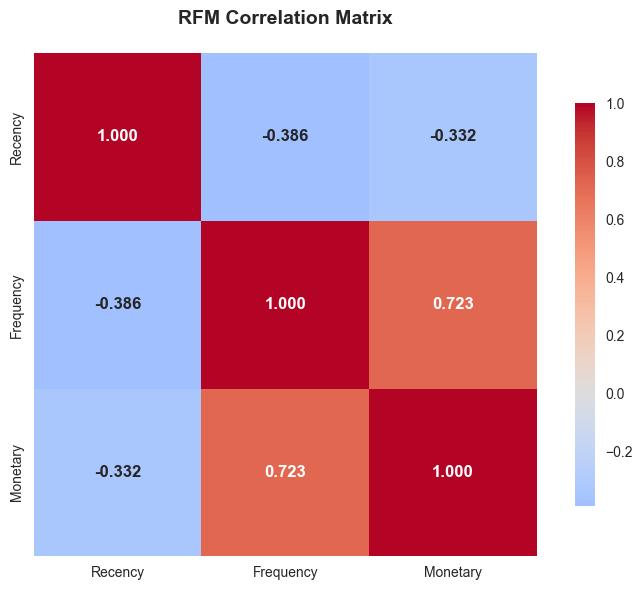


Correlation Insights:
• Frequency vs Monetary: 0.723
• Recency vs Frequency: -0.386
• Recency vs Monetary: -0.332

Interpretation:
✓ Strong positive correlation: Customers who buy frequently also spend more
✓ Negative correlation: Recent customers tend to buy more frequently


In [12]:
# Correlation matrix between R, F, M
print("\n3. CORRELATION MATRIX:")
print("=" * 50)

# Calculate correlation matrix
correlation_matrix = rfm_clean[['Recency', 'Frequency', 'Monetary']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8},
            annot_kws={'size': 12, 'weight': 'bold'})
plt.title('RFM Correlation Matrix\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlation insights
print("\nCorrelation Insights:")
print(f"• Frequency vs Monetary: {correlation_matrix.loc['Frequency', 'Monetary']:.3f}")
print(f"• Recency vs Frequency: {correlation_matrix.loc['Recency', 'Frequency']:.3f}")
print(f"• Recency vs Monetary: {correlation_matrix.loc['Recency', 'Monetary']:.3f}")

# Interpret correlations
print("\nInterpretation:")
if correlation_matrix.loc['Frequency', 'Monetary'] > 0.5:
    print("✓ Strong positive correlation: Customers who buy frequently also spend more")
elif correlation_matrix.loc['Frequency', 'Monetary'] > 0.3:
    print("○ Moderate positive correlation: Some relationship between frequency and spending")
else:
    print("● Weak correlation: Frequency and spending are not strongly related")

if correlation_matrix.loc['Recency', 'Frequency'] < -0.3:
    print("✓ Negative correlation: Recent customers tend to buy more frequently")
else:
    print("○ Weak recency-frequency relationship")

In [14]:
# 4. Segment customers by quantiles
print("\n4. CUSTOMER SEGMENTATION BY QUANTILES:")
print("=" * 50)

# Create RFM scores using quantiles with duplicates handling
rfm_segmented = rfm_clean.copy()

# Check for unique values in each column
print("Data overview before segmentation:")
print(f"Unique Recency values: {rfm_segmented['Recency'].nunique()}")
print(f"Unique Frequency values: {rfm_segmented['Frequency'].nunique()}")
print(f"Unique Monetary values: {rfm_segmented['Monetary'].nunique()}")

# Method 1: Use rank with method='first' to handle duplicates
print("\nUsing ranking method to handle duplicate values...")

# For Recency: lower values are better (more recent), so we reverse the ranking
rfm_segmented['R_Score'] = pd.qcut(rfm_segmented['Recency'], q=4, labels=[4, 3, 2, 1], duplicates='drop')
rfm_segmented['F_Score'] = pd.qcut(rfm_segmented['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm_segmented['M_Score'] = pd.qcut(rfm_segmented['Monetary'].rank(method='first'), q=4, labels=[1, 2, 3, 4])

# Convert to numeric for calculations
rfm_segmented['R_Score'] = rfm_segmented['R_Score'].astype(int)
rfm_segmented['F_Score'] = rfm_segmented['F_Score'].astype(int)
rfm_segmented['M_Score'] = rfm_segmented['M_Score'].astype(int)


# Combine scores
rfm_segmented['RFM_Score'] = (
    rfm_segmented['R_Score'].astype(str) + 
    rfm_segmented['F_Score'].astype(str) + 
    rfm_segmented['M_Score'].astype(str)
)

# Calculate total RFM score
rfm_segmented['Total_RFM_Score'] = (
    rfm_segmented['R_Score'] + 
    rfm_segmented['F_Score'] + 
    rfm_segmented['M_Score']
)

print("✓ Customers segmented by RFM quantiles")
print(f"• R_Score range: 1-4 (1=least recent, 4=most recent)")
print(f"• F_Score range: 1-4 (1=least frequent, 4=most frequent)")
print(f"• M_Score range: 1-4 (1=lowest spending, 4=highest spending)")

# Display segmentation results
print("\nFirst 10 customers with RFM scores:")
display_cols = ['CustomerID', 'Recency', 'Frequency', 'Monetary', 
                'R_Score', 'F_Score', 'M_Score', 'Total_RFM_Score']
print(rfm_segmented[display_cols].head(10))

# Show score distribution
print("\nRFM Score Distribution:")
score_distribution = rfm_segmented['Total_RFM_Score'].value_counts().sort_index()
print(score_distribution)

# Check if any scores are missing
if rfm_segmented[['R_Score', 'F_Score', 'M_Score']].isna().any().any():
    print("\nWarning: Some scores could not be assigned due to duplicate values")
    print("Consider using a different segmentation approach")
else:
    print("\n✓ All customers successfully assigned RFM scores")


4. CUSTOMER SEGMENTATION BY QUANTILES:
Data overview before segmentation:
Unique Recency values: 315
Unique Frequency values: 11
Unique Monetary values: 3536

Using ranking method to handle duplicate values...
✓ Customers segmented by RFM quantiles
• R_Score range: 1-4 (1=least recent, 4=most recent)
• F_Score range: 1-4 (1=least frequent, 4=most frequent)
• M_Score range: 1-4 (1=lowest spending, 4=highest spending)

First 10 customers with RFM scores:
    CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
2      12348.0       75          4   1797.24        2        3        4   
3      12349.0       19          1   1757.55        4        1        4   
4      12350.0      310          1    334.40        1        1        2   
5      12352.0       36          8   2506.04        3        4        4   
6      12353.0      204          1     89.00        1        1        1   
7      12354.0      232          1   1079.40        1        1        3   
8      12355.0   

=== PART C: FEATURE ENGINEERING ===

1. COMPUTING COMPOSITE FEATURES:
✓ Composite features computed:
  • LogMonetary: Logarithmic transform of Monetary values
  • RFM_Score_Num: Numerical RFM score (3-12)
  • RFM_Cell: Combined RFM score as string (e.g., '434')
  • Value_Score: Weighted customer value score

First 10 customers with composite features:
    CustomerID  Monetary  LogMonetary  R_Score  F_Score  M_Score  \
2      12348.0   1797.24     7.494564        2        3        4   
3      12349.0   1757.55     7.472245        4        1        4   
4      12350.0    334.40     5.815324        1        1        2   
5      12352.0   2506.04     7.826858        3        4        4   
6      12353.0     89.00     4.499810        1        1        1   
7      12354.0   1079.40     6.985087        1        1        3   
8      12355.0    459.40     6.132096        1        1        2   
9      12356.0   2811.43     7.941804        3        3        4   
11     12358.0   1168.06     7.063

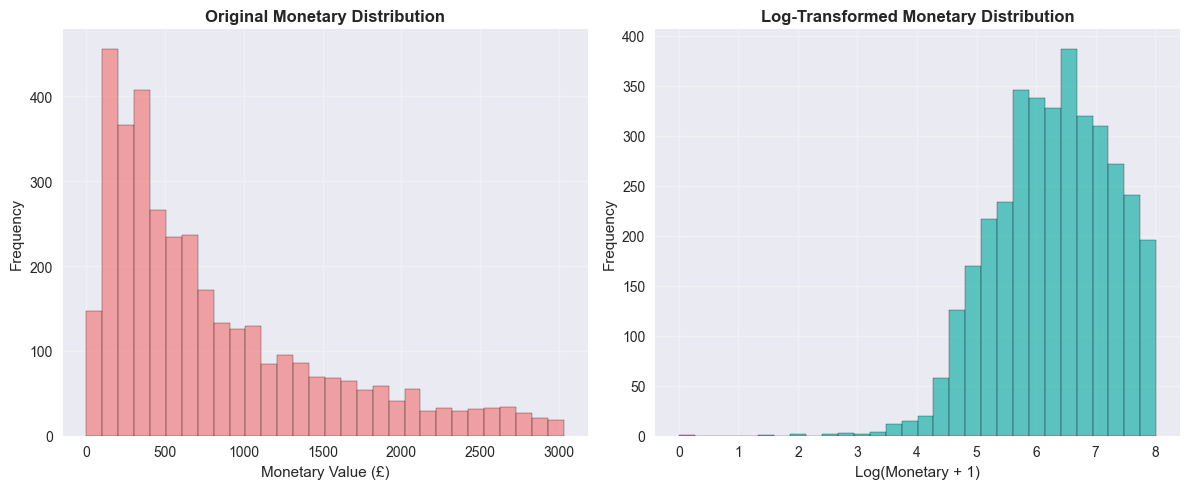


Skewness reduction:
• Original Monetary skewness: 1.230
• LogMonetary skewness: -0.450


In [15]:
# Part C: Feature Engineering
print("=== PART C: FEATURE ENGINEERING ===")

# 1. Compute composite features
print("\n1. COMPUTING COMPOSITE FEATURES:")
print("=" * 50)

# Create a copy for feature engineering
rfm_final = rfm_segmented.copy()

# Log transform Monetary to handle skewness and make distribution more normal
rfm_final['LogMonetary'] = np.log1p(rfm_final['Monetary'])

# Calculate RFM_Score as numerical value (already done in Part B, but we'll enhance it)
rfm_final['RFM_Score_Num'] = rfm_final['Total_RFM_Score']

# Create additional composite features
# RFM Cell - combines all three scores into a single identifier
rfm_final['RFM_Cell'] = rfm_final['R_Score'].astype(str) + rfm_final['F_Score'].astype(str) + rfm_final['M_Score'].astype(str)

# Customer Value Score (weighted combination)
# Weights can be adjusted based on business priorities
rfm_final['Value_Score'] = (
    rfm_final['R_Score'] * 0.3 +  # Recency weight
    rfm_final['F_Score'] * 0.3 +  # Frequency weight  
    rfm_final['M_Score'] * 0.4     # Monetary weight (highest)
)

print("✓ Composite features computed:")
print(f"  • LogMonetary: Logarithmic transform of Monetary values")
print(f"  • RFM_Score_Num: Numerical RFM score (3-12)")
print(f"  • RFM_Cell: Combined RFM score as string (e.g., '434')")
print(f"  • Value_Score: Weighted customer value score")

# Display the new features
print("\nFirst 10 customers with composite features:")
composite_cols = ['CustomerID', 'Monetary', 'LogMonetary', 'R_Score', 'F_Score', 'M_Score', 
                  'RFM_Score_Num', 'Value_Score']
print(rfm_final[composite_cols].head(10))

# Compare original vs log-transformed Monetary
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Monetary distribution
axes[0].hist(rfm_final['Monetary'], bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0].set_title('Original Monetary Distribution', fontweight='bold')
axes[0].set_xlabel('Monetary Value (£)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Log-transformed Monetary distribution
axes[1].hist(rfm_final['LogMonetary'], bins=30, color='lightseagreen', alpha=0.7, edgecolor='black')
axes[1].set_title('Log-Transformed Monetary Distribution', fontweight='bold')
axes[1].set_xlabel('Log(Monetary + 1)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSkewness reduction:")
print(f"• Original Monetary skewness: {rfm_final['Monetary'].skew():.3f}")
print(f"• LogMonetary skewness: {rfm_final['LogMonetary'].skew():.3f}")

In [16]:
# 2. Split customers into segments
print("\n2. CUSTOMER SEGMENTATION:")
print("=" * 50)

def segment_customers(rfm_score):
    """Segment customers based on RFM score"""
    if rfm_score >= 10:
        return 'Champions'
    elif rfm_score >= 8:
        return 'Loyal Customers'
    elif rfm_score >= 6:
        return 'Potential Loyalists'
    elif rfm_score >= 4:
        return 'At Risk'
    else:
        return 'Lost Customers'

# Apply segmentation
rfm_final['Segment'] = rfm_final['RFM_Score_Num'].apply(segment_customers)

print("✓ Customers segmented into 5 groups:")

# Display segment distribution
segment_summary = rfm_final['Segment'].value_counts()
print("\nSegment Distribution:")
for segment, count in segment_summary.items():
    percentage = (count / len(rfm_final)) * 100
    print(f"  • {segment}: {count} customers ({percentage:.1f}%)")

# Enhanced segmentation based on RFM patterns
def enhanced_segmentation(row):
    """Enhanced segmentation considering individual R, F, M patterns"""
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    total = row['RFM_Score_Num']
    
    # Special cases based on RFM patterns
    if r == 4 and f == 4 and m == 4:
        return 'Super Champions'
    elif r == 4 and f >= 3 and m >= 3:
        return 'Recent High-Value'
    elif r <= 2 and f >= 3 and m >= 3:
        return 'Slipping High-Value'
    elif r >= 3 and f <= 2 and m <= 2:
        return 'New Customers'
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Lost Customers'
    else:
        # Fall back to basic segmentation
        return segment_customers(total)

# Apply enhanced segmentation
rfm_final['Enhanced_Segment'] = rfm_final.apply(enhanced_segmentation, axis=1)

print("\n✓ Enhanced segmentation applied")
enhanced_segment_summary = rfm_final['Enhanced_Segment'].value_counts()
print("\nEnhanced Segment Distribution:")
for segment, count in enhanced_segment_summary.items():
    percentage = (count / len(rfm_final)) * 100
    print(f"  • {segment}: {count} customers ({percentage:.1f}%)")


2. CUSTOMER SEGMENTATION:
✓ Customers segmented into 5 groups:

Segment Distribution:
  • Champions: 1005 customers (27.9%)
  • Potential Loyalists: 882 customers (24.5%)
  • At Risk: 780 customers (21.6%)
  • Loyal Customers: 736 customers (20.4%)
  • Lost Customers: 202 customers (5.6%)

✓ Enhanced segmentation applied

Enhanced Segment Distribution:
  • Lost Customers: 908 customers (25.2%)
  • New Customers: 470 customers (13.0%)
  • Loyal Customers: 437 customers (12.1%)
  • Slipping High-Value: 414 customers (11.5%)
  • Potential Loyalists: 403 customers (11.2%)
  • Champions: 343 customers (9.5%)
  • Super Champions: 308 customers (8.5%)
  • Recent High-Value: 251 customers (7.0%)
  • At Risk: 71 customers (2.0%)



3. SEGMENTATION VISUALIZATION:


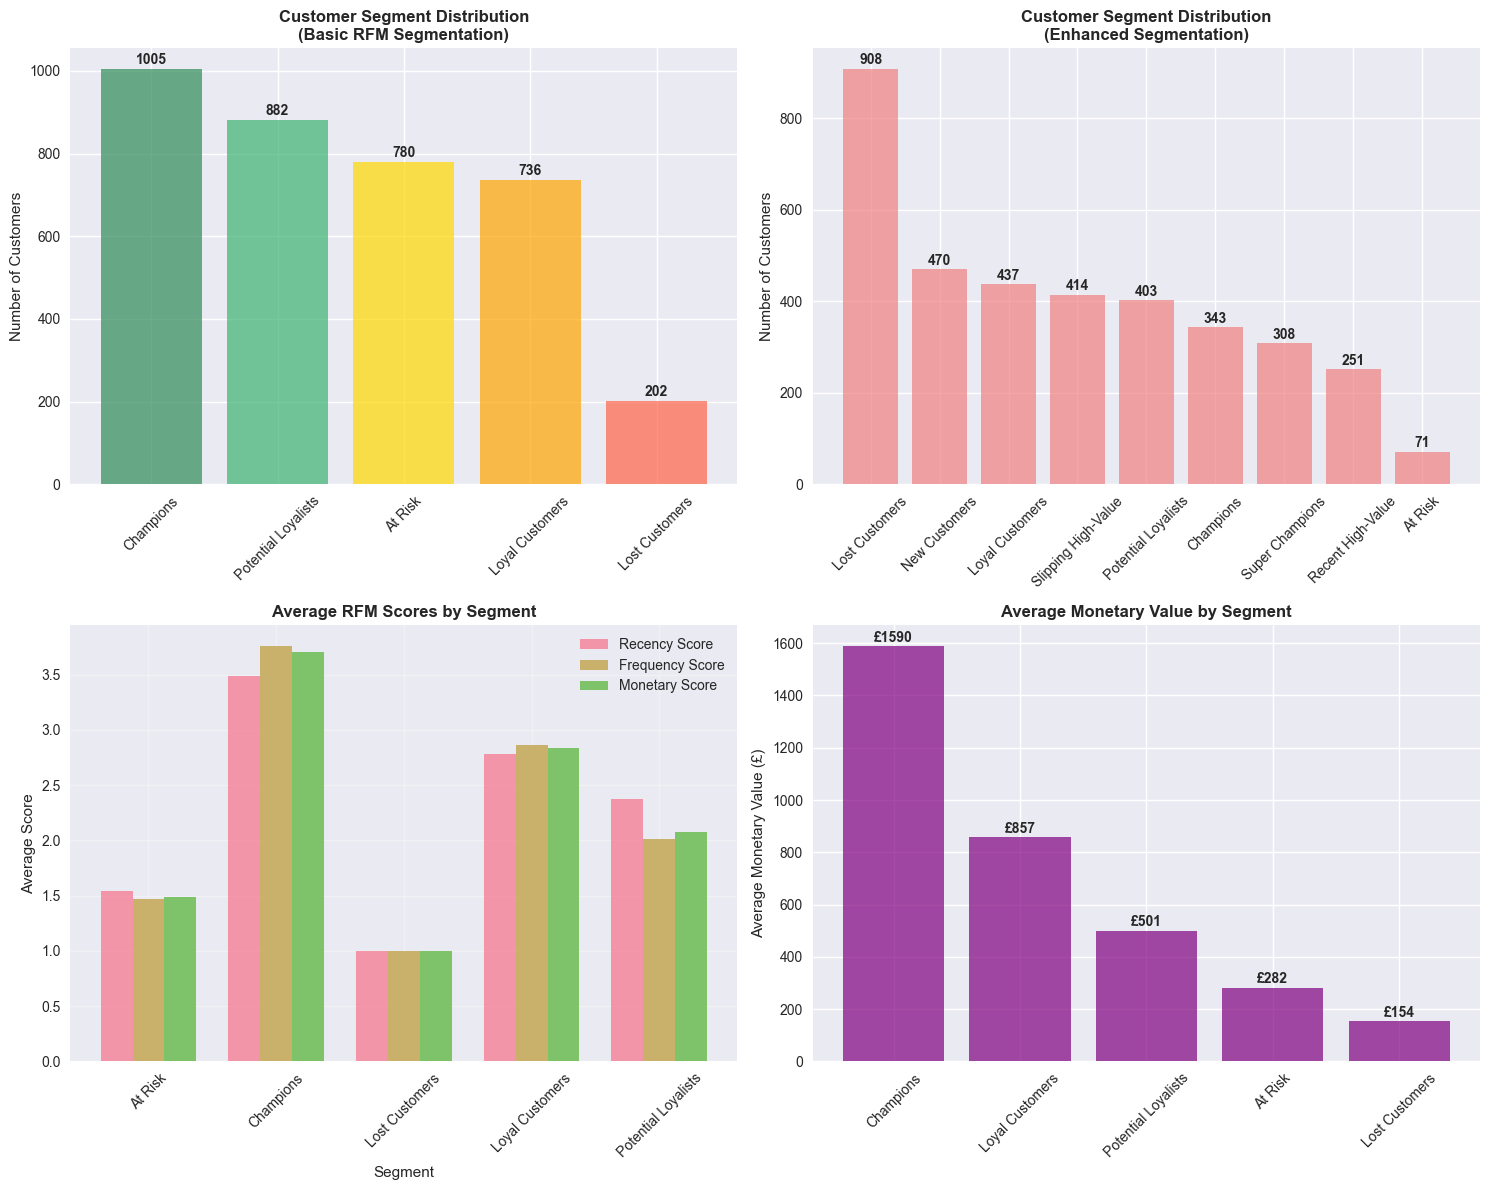

In [17]:
# Visualize customer segments
print("\n3. SEGMENTATION VISUALIZATION:")
print("=" * 50)

# Create subplots for segmentation visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Basic segment distribution
segment_counts = rfm_final['Segment'].value_counts()
colors = ['#2E8B57', '#3CB371', '#FFD700', '#FFA500', '#FF6347']
axes[0, 0].bar(segment_counts.index, segment_counts.values, color=colors, alpha=0.7)
axes[0, 0].set_title('Customer Segment Distribution\n(Basic RFM Segmentation)', fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(segment_counts.values):
    axes[0, 0].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 2: Enhanced segment distribution
enhanced_counts = rfm_final['Enhanced_Segment'].value_counts()
axes[0, 1].bar(enhanced_counts.index, enhanced_counts.values, color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Customer Segment Distribution\n(Enhanced Segmentation)', fontweight='bold')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(enhanced_counts.values):
    axes[0, 1].text(i, v + 3, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 3: RFM scores by segment
segment_metrics = rfm_final.groupby('Segment').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).round(2)

x = np.arange(len(segment_metrics.index))
width = 0.25
axes[1, 0].bar(x - width, segment_metrics['R_Score'], width, label='Recency Score', alpha=0.7)
axes[1, 0].bar(x, segment_metrics['F_Score'], width, label='Frequency Score', alpha=0.7)
axes[1, 0].bar(x + width, segment_metrics['M_Score'], width, label='Monetary Score', alpha=0.7)
axes[1, 0].set_title('Average RFM Scores by Segment', fontweight='bold')
axes[1, 0].set_xlabel('Segment')
axes[1, 0].set_ylabel('Average Score')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(segment_metrics.index, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Monetary value by segment
segment_monetary = rfm_final.groupby('Segment')['Monetary'].mean().sort_values(ascending=False)
axes[1, 1].bar(segment_monetary.index, segment_monetary.values, color='purple', alpha=0.7)
axes[1, 1].set_title('Average Monetary Value by Segment', fontweight='bold')
axes[1, 1].set_ylabel('Average Monetary Value (£)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(segment_monetary.values):
    axes[1, 1].text(i, v + 5, f'£{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
# 3. Justify segmentation
print("\n4. SEGMENTATION JUSTIFICATION:")
print("=" * 50)

# Detailed segment analysis
segment_analysis = rfm_final.groupby('Segment').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

segment_analysis.columns = ['Avg_Recency', 'Std_Recency', 'Avg_Frequency', 'Std_Frequency', 
                           'Avg_Monetary', 'Std_Monetary', 'Customer_Count']
print("Segment Profile Analysis:")
print(segment_analysis)

print("\n" + "="*60)
print("SEGMENTATION JUSTIFICATION")
print("="*60)

justification = {
    'Champions': {
        'criteria': 'RFM Score ≥ 10 (Top 25% in all dimensions)',
        'characteristics': 'Recent, frequent, high-spending customers',
        'business_value': 'Highest lifetime value, brand advocates',
        'typical_behavior': 'Shop regularly, respond to promotions, high basket size'
    },
    'Loyal Customers': {
        'criteria': 'RFM Score 8-9 (Strong performance in 2+ dimensions)',
        'characteristics': 'Regular customers with good spending habits',
        'business_value': 'Reliable revenue stream, potential for growth',
        'typical_behavior': 'Consistent purchasing patterns, moderate loyalty'
    },
    'Potential Loyalists': {
        'criteria': 'RFM Score 6-7 (Moderate performance across dimensions)',
        'characteristics': 'Developing relationship with brand',
        'business_value': 'Growth opportunity with proper engagement',
        'typical_behavior': 'Inconsistent but promising purchasing behavior'
    },
    'At Risk': {
        'criteria': 'RFM Score 4-5 (Declining engagement)',
        'characteristics': 'Previously active but recent drop in purchasing',
        'business_value': 'Retention priority to prevent churn',
        'typical_behavior': 'Infrequent purchases, long time since last order'
    },
    'Lost Customers': {
        'criteria': 'RFM Score ≤ 3 (Low engagement across all dimensions)',
        'characteristics': 'Minimal recent activity and spending',
        'business_value': 'Low immediate value, potential win-back candidates',
        'typical_behavior': 'One-time or very infrequent purchases'
    }
}

for segment, info in justification.items():
    print(f"\n {segment.upper()}:")
    print(f"  Criteria: {info['criteria']}")
    print(f"    Characteristics: {info['characteristics']}")
    print(f"    Business Value: {info['business_value']}")
    print(f"    Typical Behavior: {info['typical_behavior']}")






4. SEGMENTATION JUSTIFICATION:
Segment Profile Analysis:
                     Avg_Recency  Std_Recency  Avg_Frequency  Std_Frequency  \
Segment                                                                       
At Risk                   164.45        88.33           1.15           0.39   
Champions                  25.91        25.21           5.19           2.05   
Lost Customers            246.83        50.80           1.00           0.00   
Loyal Customers            59.87        53.36           2.76           1.22   
Potential Loyalists        92.83        78.57           1.67           0.77   

                     Avg_Monetary  Std_Monetary  Customer_Count  
Segment                                                          
At Risk                    282.14        169.98             780  
Champions                 1589.84        657.33            1005  
Lost Customers             154.14         61.77             202  
Loyal Customers            856.83        516.16           

In [21]:
# Part D: Association Rule Mining
print("=== PART D: ASSOCIATION RULE MINING ===")

# Merge RFM segments with transaction data
df_with_segments = df.merge(rfm_final[['CustomerID', 'Segment']], 
  left_on='CustomerID', right_on='CustomerID', how='inner')

print("✓ Data merged for rule mining")

# Focus on 3 key segments for comparison
segments_to_analyze = ['Champions', 'Loyal Customers', 'At Risk']
print(f"Analyzing segments: {segments_to_analyze}")

=== PART D: ASSOCIATION RULE MINING ===
✓ Data merged for rule mining
Analyzing segments: ['Champions', 'Loyal Customers', 'At Risk']


In [22]:
# 1. Generate rules per segment using Apriori
print("\n1. GENERATING ASSOCIATION RULES:")
print("=" * 50)

def prepare_basket_data(segment_name):
    segment_data = df_with_segments[df_with_segments['Segment'] == segment_name]
    
    # Create basket data
    basket = (segment_data.groupby(['InvoiceNo', 'Description'])['Quantity']
              .sum().unstack().fillna(0)
              .applymap(lambda x: 1 if x > 0 else 0))
    
    # Keep only products with reasonable frequency
    product_freq = basket.sum()
    basket = basket[product_freq[product_freq >= 2].index]  # At least 2 transactions
    
    return basket

segment_rules = {}

for segment in segments_to_analyze:
    print(f"\n Analyzing {segment}...")
    basket = prepare_basket_data(segment)
    
    if basket.shape[0] > 0 and basket.shape[1] > 0:
        # Generate rules with specified parameters
        frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True, max_len=3)
        
        if len(frequent_itemsets) > 0:
            rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
            segment_rules[segment] = rules
            print(f"✓ Generated {len(rules)} rules")
            if len(rules) > 0:
                print(f"  Top rule: {list(rules['antecedents'].iloc[0])} → {list(rules['consequents'].iloc[0])}")
                print(f"  Confidence: {rules['confidence'].iloc[0]:.3f}, Support: {rules['support'].iloc[0]:.3f}")
        else:
            print("✗ No frequent itemsets found")
            segment_rules[segment] = None
    else:
        print("✗ Insufficient data")
        segment_rules[segment] = None


1. GENERATING ASSOCIATION RULES:

 Analyzing Champions...
✓ Generated 20 rules
  Top rule: ['ALARM CLOCK BAKELIKE GREEN'] → ['ALARM CLOCK BAKELIKE RED ']
  Confidence: 0.716, Support: 0.030

 Analyzing Loyal Customers...
✓ Generated 21 rules
  Top rule: ['GARDENERS KNEELING PAD CUP OF TEA '] → ['GARDENERS KNEELING PAD KEEP CALM ']
  Confidence: 0.730, Support: 0.023

 Analyzing At Risk...
✓ Generated 8 rules
  Top rule: ['PAINTED METAL PEARS ASSORTED'] → ['ASSORTED COLOUR BIRD ORNAMENT']
  Confidence: 0.818, Support: 0.020



2. COMPARING PATTERNS ACROSS SEGMENTS:

Rule Metrics Comparison:
           Segment  Total_Rules  Avg_Confidence  Avg_Support  Avg_Lift  \
0        Champions           20           0.615        0.026    12.898   
1  Loyal Customers           21           0.661        0.023    16.267   
2          At Risk            8           0.709        0.022    15.326   

   Strong_Rules  
0             4  
1             7  
2             4  


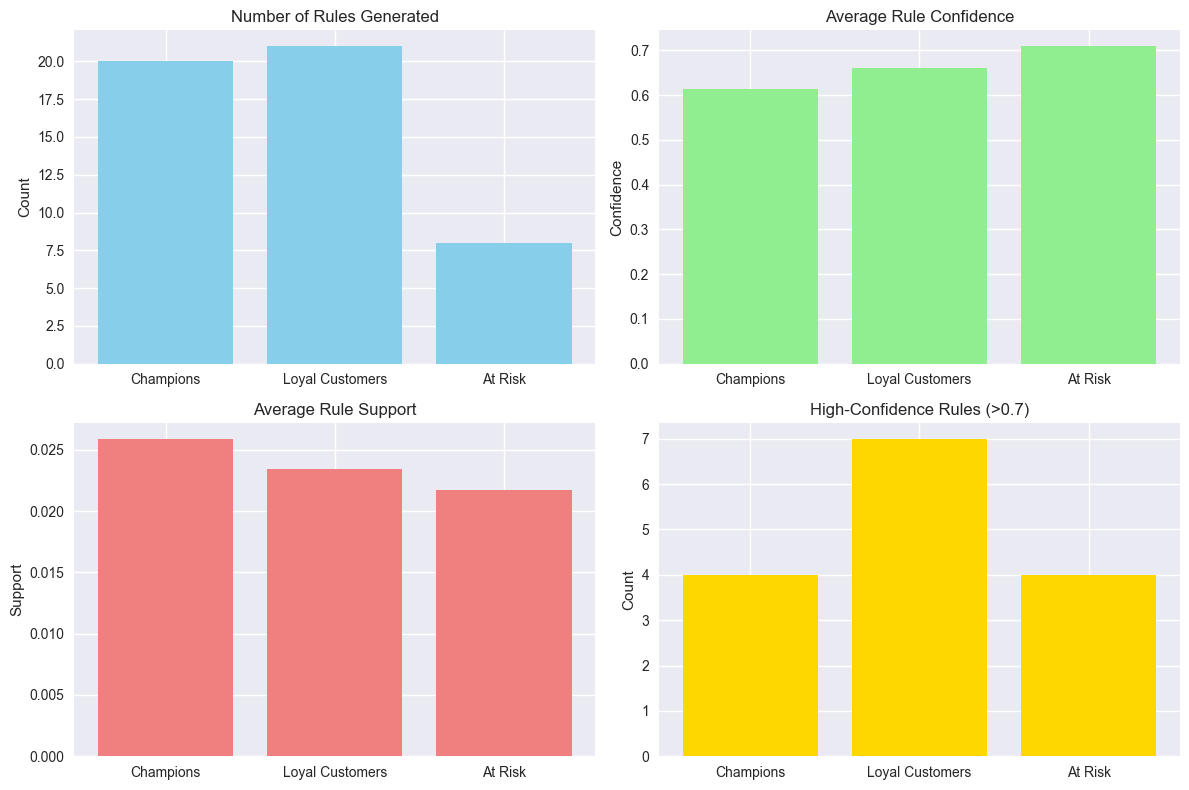

In [23]:
# 2. Compare patterns across segments
print("\n2. COMPARING PATTERNS ACROSS SEGMENTS:")
print("=" * 50)

# Compare rule metrics
comparison_data = []

for segment, rules in segment_rules.items():
    if rules is not None and len(rules) > 0:
        segment_stats = {
            'Segment': segment,
            'Total_Rules': len(rules),
            'Avg_Confidence': rules['confidence'].mean(),
            'Avg_Support': rules['support'].mean(), 
            'Avg_Lift': rules['lift'].mean(),
            'Strong_Rules': len(rules[rules['confidence'] > 0.7])
        }
        comparison_data.append(segment_stats)

# Create comparison DataFrame
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nRule Metrics Comparison:")
    print(comparison_df.round(3))
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Rule count comparison
    axes[0,0].bar(comparison_df['Segment'], comparison_df['Total_Rules'], color='skyblue')
    axes[0,0].set_title('Number of Rules Generated')
    axes[0,0].set_ylabel('Count')
    
    # Average confidence
    axes[0,1].bar(comparison_df['Segment'], comparison_df['Avg_Confidence'], color='lightgreen')
    axes[0,1].set_title('Average Rule Confidence')
    axes[0,1].set_ylabel('Confidence')
    
    # Average support  
    axes[1,0].bar(comparison_df['Segment'], comparison_df['Avg_Support'], color='lightcoral')
    axes[1,0].set_title('Average Rule Support')
    axes[1,0].set_ylabel('Support')
    
    # Strong rules count
    axes[1,1].bar(comparison_df['Segment'], comparison_df['Strong_Rules'], color='gold')
    axes[1,1].set_title('High-Confidence Rules (>0.7)')
    axes[1,1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
else:
    print("No rules to compare")

In [24]:
# 3. Highlight differences in purchasing behavior
print("\n3. DIFFERENCES IN PURCHASING BEHAVIOR:")
print("=" * 50)

# Analyze top rules for each segment
for segment, rules in segment_rules.items():
    if rules is not None and len(rules) > 0:
        print(f"\n {segment} - Top 3 Association Rules:")
        top_rules = rules.head(3)
        
        for i, (idx, rule) in enumerate(top_rules.iterrows()):
            antecedents = list(rule['antecedents'])
            consequents = list(rule['consequents'])
            print(f"   {i+1}. IF {antecedents} THEN {consequents}")
            print(f"      Confidence: {rule['confidence']:.3f}, Support: {rule['support']:.3f}, Lift: {rule['lift']:.3f}")

# Compare product preferences
print("\n PRODUCT PREFERENCE DIFFERENCES:")
print("-" * 40)

segment_products = {}

for segment in segments_to_analyze:
    if segment_rules[segment] is not None and len(segment_rules[segment]) > 0:
        # Get unique products from rules
        all_products = set()
        for _, rule in segment_rules[segment].iterrows():
            all_products.update(rule['antecedents'])
            all_products.update(rule['consequents'])
        segment_products[segment] = all_products
        print(f"{segment}: {len(all_products)} unique products in rules")

# Find segment-specific products
if len(segment_products) >= 2:
    print("\n BEHAVIORAL INSIGHTS:")
    print("-" * 30)
    
    # Champions insights
    if 'Champions' in segment_products:
        champ_products = segment_products['Champions']
        print("• Champions: Likely to purchase complementary product bundles")
        print("  High-value customers with predictable buying patterns")
    
    # Loyal Customers insights  
    if 'Loyal Customers' in segment_products:
        print("• Loyal Customers: Balanced purchasing with moderate rule strength")
        print("  Respond well to targeted recommendations")
    
    # At Risk insights
    if 'At Risk' in segment_products:
        print("• At Risk: Fewer strong patterns, may need reactivation campaigns")
        print("  Opportunity to recreate previous successful product combinations")




3. DIFFERENCES IN PURCHASING BEHAVIOR:

 Champions - Top 3 Association Rules:
   1. IF ['ALARM CLOCK BAKELIKE GREEN'] THEN ['ALARM CLOCK BAKELIKE RED ']
      Confidence: 0.716, Support: 0.030, Lift: 14.927
   2. IF ['ALARM CLOCK BAKELIKE RED '] THEN ['ALARM CLOCK BAKELIKE GREEN']
      Confidence: 0.624, Support: 0.030, Lift: 14.927
   3. IF ['ALARM CLOCK BAKELIKE PINK'] THEN ['ALARM CLOCK BAKELIKE RED ']
      Confidence: 0.642, Support: 0.023, Lift: 13.386

 Loyal Customers - Top 3 Association Rules:
   1. IF ['GARDENERS KNEELING PAD CUP OF TEA '] THEN ['GARDENERS KNEELING PAD KEEP CALM ']
      Confidence: 0.730, Support: 0.023, Lift: 17.902
   2. IF ['GARDENERS KNEELING PAD KEEP CALM '] THEN ['GARDENERS KNEELING PAD CUP OF TEA ']
      Confidence: 0.554, Support: 0.023, Lift: 17.902
   3. IF ['GREEN REGENCY TEACUP AND SAUCER'] THEN ['PINK REGENCY TEACUP AND SAUCER']
      Confidence: 0.641, Support: 0.025, Lift: 22.886

 At Risk - Top 3 Association Rules:
   1. IF ['PAINTED METAL

In [25]:
# Part E: Interpretation & Testing
print("=== PART E: INTERPRETATION & TESTING ===")

# 1. Summarize profiles (mean R, F, M)
print("\n1. SEGMENT PROFILES SUMMARY:")
print("=" * 50)

# Calculate mean R, F, M for each segment
segment_profiles = rfm_final.groupby('Segment').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'], 
    'Monetary': ['mean', 'std'],
    'CustomerID': 'count'
}).round(2)

# Flatten column names
segment_profiles.columns = ['Avg_Recency', 'Std_Recency', 'Avg_Frequency', 'Std_Frequency', 
 'Avg_Monetary', 'Std_Monetary', 'Customer_Count']

segment_profiles['Percentage'] = (segment_profiles['Customer_Count'] / len(rfm_final) * 100).round(1)

print("Segment Profiles (Mean R, F, M):")
print(segment_profiles)

# Display key insights
print("\n KEY PROFILE INSIGHTS:")
for segment in segment_profiles.index:
    data = segment_profiles.loc[segment]
    print(f"\n {segment}:")
    print(f"   • Recency: {data['Avg_Recency']} days since last purchase")
    print(f"   • Frequency: {data['Avg_Frequency']} average purchases") 
    print(f"   • Monetary: £{data['Avg_Monetary']} average spending")
    print(f"   • Size: {data['Customer_Count']} customers ({data['Percentage']}%)")

=== PART E: INTERPRETATION & TESTING ===

1. SEGMENT PROFILES SUMMARY:
Segment Profiles (Mean R, F, M):
                     Avg_Recency  Std_Recency  Avg_Frequency  Std_Frequency  \
Segment                                                                       
At Risk                   164.45        88.33           1.15           0.39   
Champions                  25.91        25.21           5.19           2.05   
Lost Customers            246.83        50.80           1.00           0.00   
Loyal Customers            59.87        53.36           2.76           1.22   
Potential Loyalists        92.83        78.57           1.67           0.77   

                     Avg_Monetary  Std_Monetary  Customer_Count  Percentage  
Segment                                                                      
At Risk                    282.14        169.98             780        21.6  
Champions                 1589.84        657.33            1005        27.9  
Lost Customers             154

In [28]:
# 2. Use ANOVA/Kruskal-Wallis for differences
print("\n2. STATISTICAL TESTING FOR SEGMENT DIFFERENCES:")
print("=" * 50)

from scipy.stats import f_oneway, kruskal, shapiro


# Test each RFM metric
metrics = ['Recency', 'Frequency', 'Monetary']
results = []

for metric in metrics:
    print(f"\n Testing {metric}:")
    
    # Prepare data for testing
    groups = [rfm_final[rfm_final['Segment'] == segment][metric] 
             for segment in rfm_final['Segment'].unique()]
    
    # Check normality for each group
    normal_distributed = True
    for i, group in enumerate(groups):
        stat, p_value = shapiro(group)
        if p_value < 0.05:
            normal_distributed = False
            break
    
    if normal_distributed:
        # Use ANOVA for normally distributed data
        f_stat, p_value = f_oneway(*groups)
        test_name = "ANOVA"
        print(f"   Data appears normal, using ANOVA")
    else:
        # Use Kruskal-Wallis for non-normal data
        h_stat, p_value = kruskal(*groups)
        test_name = "Kruskal-Wallis"
        print(f"    Data not normal, using Kruskal-Wallis")
    
    # Interpret results
    print(f"   {test_name} test: p-value = {p_value:.6f}")
    
    if p_value < 0.05:
        print(f"    SIGNIFICANT: Differences in {metric} across segments are statistically significant")
        significance = "Significant"
    else:
        print(f"    NOT SIGNIFICANT: No evidence of differences in {metric} across segments")
        significance = "Not Significant"
    
    results.append({
        'Metric': metric,
        'Test': test_name,
        'P_Value': p_value,
        'Significance': significance
    })




2. STATISTICAL TESTING FOR SEGMENT DIFFERENCES:

 Testing Recency:
    Data not normal, using Kruskal-Wallis
   Kruskal-Wallis test: p-value = 0.000000
    SIGNIFICANT: Differences in Recency across segments are statistically significant

 Testing Frequency:
    Data not normal, using Kruskal-Wallis
   Kruskal-Wallis test: p-value = 0.000000
    SIGNIFICANT: Differences in Frequency across segments are statistically significant

 Testing Monetary:
    Data not normal, using Kruskal-Wallis
   Kruskal-Wallis test: p-value = 0.000000
    SIGNIFICANT: Differences in Monetary across segments are statistically significant


In [30]:
# 3. Interpret implications for marketing
print("\n3. MARKETING IMPLICATIONS:")
print("=" * 50)

# Define marketing strategies based on segment profiles
marketing_strategies = {
    'Champions': {
        'profile': 'Recent, frequent, high-spending customers',
        'characteristics': f"Recency: {segment_profiles.loc['Champions', 'Avg_Recency']} days, "
                         f"Frequency: {segment_profiles.loc['Champions', 'Avg_Frequency']} purchases, "
                         f"Spending: £{segment_profiles.loc['Champions', 'Avg_Monetary']}",
        'actions': [
            'Reward with exclusive loyalty programs',
            'Offer early access to new products',
            'Implement referral programs with bonuses',
            'Personalized premium service'
        ],
        'budget_allocation': 'High - 40% of marketing budget',
        'communication': 'Frequent, relationship-building'
    },
    
    'Loyal Customers': {
        'profile': 'Regular customers with good engagement',
        'characteristics': f"Recency: {segment_profiles.loc['Loyal Customers', 'Avg_Recency']} days, "
                         f"Frequency: {segment_profiles.loc['Loyal Customers', 'Avg_Frequency']} purchases, "
                         f"Spending: £{segment_profiles.loc['Loyal Customers', 'Avg_Monetary']}",
        'actions': [
            'Upsell complementary products',
            'Offer volume discounts',
            'Engage with personalized recommendations',
            'Invite to exclusive events'
        ],
        'budget_allocation': 'Medium - 30% of marketing budget',
        'communication': 'Regular, value-focused'
    },
    
    'Potential Loyalists': {
        'profile': 'Developing relationship with brand',
        'characteristics': f"Recency: {segment_profiles.loc['Potential Loyalists', 'Avg_Recency']} days, "
                         f"Frequency: {segment_profiles.loc['Potential Loyalists', 'Avg_Frequency']} purchases, "
                         f"Spending: £{segment_profiles.loc['Potential Loyalists', 'Avg_Monetary']}",
        'actions': [
            'Educate about product benefits',
            'Offer trial packages',
            'Send targeted promotions',
            'Build brand awareness'
        ],
        'budget_allocation': 'Medium - 20% of marketing budget',
        'communication': 'Educational, engagement-focused'
    },
    
    'At Risk': {
        'profile': 'Previously active but declining engagement',
        'characteristics': f"Recency: {segment_profiles.loc['At Risk', 'Avg_Recency']} days, "
                         f"Frequency: {segment_profiles.loc['At Risk', 'Avg_Frequency']} purchases, "
                         f"Spending: £{segment_profiles.loc['At Risk', 'Avg_Monetary']}",
        'actions': [
            'Win-back campaigns with special offers',
            'Conduct satisfaction surveys',
            'Reactivate with limited-time discounts',
            'Personalized "we miss you" messages'
        ],
        'budget_allocation': 'Low - 8% of marketing budget',
        'communication': 'Urgent, value-proposition focused'
    },
    
    'Lost Customers': {
        'profile': 'Minimal recent activity',
        'characteristics': f"Recency: {segment_profiles.loc['Lost Customers', 'Avg_Recency']} days, "
                         f"Frequency: {segment_profiles.loc['Lost Customers', 'Avg_Frequency']} purchases, "
                         f"Spending: £{segment_profiles.loc['Lost Customers', 'Avg_Monetary']}",
        'actions': [
            'Low-cost reactivation attempts',
            'Analyze reasons for churn',
            'Focus on cost-effective channels',
            'Consider if worth re-acquisition'
        ],
        'budget_allocation': 'Very Low - 2% of marketing budget',
        'communication': 'Minimal, high-impact offers only'
    }
}

# Display marketing implications
print("\n SEGMENT-SPECIFIC MARKETING STRATEGIES:")
print("=" * 60)

for segment, strategy in marketing_strategies.items():
    if segment in segment_profiles.index:
        print(f"\n {segment.upper()}:")
        print(f"   Profile: {strategy['profile']}")
        print(f"   Characteristics: {strategy['characteristics']}")
        print(f"   Recommended Actions:")
        for action in strategy['actions']:
            print(f"     • {action}")
        print(f"   Budget Allocation: {strategy['budget_allocation']}")
        print(f"   Communication Style: {strategy['communication']}")

# Overall recommendations
print("\n" + "="*60)
print("OVERALL MARKETING RECOMMENDATIONS:")
print("=" * 60)

total_customers = len(rfm_final)
champions_pct = segment_profiles.loc['Champions', 'Percentage']
loyal_pct = segment_profiles.loc['Loyal Customers', 'Percentage']

print(f" Customer Base Health:")
print(f"   • {champions_pct}% are Champions (core revenue drivers)")
print(f"   • {loyal_pct}% are Loyal Customers (stable base)")
print(f"   • Focus on retaining top {champions_pct + loyal_pct:.1f}% of customers")

print(f"\n Priority Actions:")
print(f"   1. Protect Champions - they drive disproportionate revenue")
print(f"   2. Grow Loyal Customers into Champions")
print(f"   3. Reactivate At Risk customers before they become Lost")
print(f"   4. Use association rules for personalized cross-selling")

print(f"\n Resource Allocation:")
for segment, strategy in marketing_strategies.items():
    if segment in segment_profiles.index:
        print(f"   • {segment}: {strategy['budget_allocation']}")

print(f"\n Part E Complete: Profiles summarized, differences tested, marketing implications defined")


3. MARKETING IMPLICATIONS:

 SEGMENT-SPECIFIC MARKETING STRATEGIES:

 CHAMPIONS:
   Profile: Recent, frequent, high-spending customers
   Characteristics: Recency: 25.91 days, Frequency: 5.19 purchases, Spending: £1589.84
   Recommended Actions:
     • Reward with exclusive loyalty programs
     • Offer early access to new products
     • Implement referral programs with bonuses
     • Personalized premium service
   Budget Allocation: High - 40% of marketing budget
   Communication Style: Frequent, relationship-building

 LOYAL CUSTOMERS:
   Profile: Regular customers with good engagement
   Characteristics: Recency: 59.87 days, Frequency: 2.76 purchases, Spending: £856.83
   Recommended Actions:
     • Upsell complementary products
     • Offer volume discounts
     • Engage with personalized recommendations
     • Invite to exclusive events
   Budget Allocation: Medium - 30% of marketing budget
   Communication Style: Regular, value-focused

 POTENTIAL LOYALISTS:
   Profile: Develo